# OOI Pioneer Profiler Moorings

Taking [OOI Pioneer array data](https://dataexplorer.oceanobservatories.org) and wiriting it in [`profiles`](https://mitgcm.readthedocs.io/en/latest/ocean_state_est/ocean_state_est.html#profiles-model-data-comparisons-at-observed-locations) package format.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import os
import warnings
warnings.simplefilter('ignore')
os.environ['PYTHONWARNOINGS'] = 'ignore'

## Load OOI DataSets

In [2]:
import sandbox.ooi_pioneer as ooi

In [3]:
dataPath = '/scratch2/shared/ooi-pioneer/'
dataFiles = os.listdir(dataPath)[5:]

In [4]:
ds = {}
for file in dataFiles:
    ds[file[0 : file.index('.')]] = ooi.readOOI(dataPath + file)
    # visual check if depth values are whole numbers
    #(ds[file[0 : file.index('.')]].prof_depth%1).plot() 

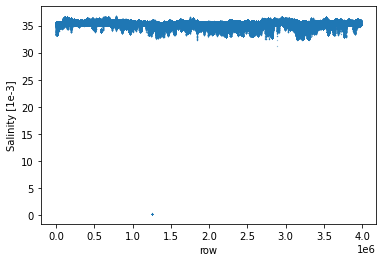

In [6]:
ds['cp04ospm'].prof_S.plot(x='row',
                              marker='o', linewidth=0.,
                              markersize=0.2)

## Dev

development of iDEPTH, iPROF dimensions

Based on notes in Sverdrup (~atnguyen/llc270/global/matlab/simple_ctd/README*.txt), we should attach mooring data to closest depth. 

In [8]:
dsTest = ds['cp04ospm']
dsTest

<xarray.Dataset>
Dimensions:        (iPROF: 371522, row: 3978245)
Coordinates:
  * iPROF          (iPROF) datetime64[ns] 2014-04-15T20:00:00 ... 2021-08-22T...
Dimensions without coordinates: row
Data variables:
    time           (row) datetime64[ns] 2014-04-15T20:00:00 ... 2021-08-22T18...
    prof_S         (row) float64 ...
    prof_T         (row) float64 ...
    prof_Sflag     (row) float64 ...
    prof_Tflag     (row) float64 ...
    prof_depth     (row) float64 27.0 26.0 27.0 26.0 ... 397.0 396.0 406.0 406.0
    prof_YYYYMMDD  (row) float64 2.014e+07 2.014e+07 ... 2.021e+07 2.021e+07
    prof_HHMMSS    (row) float64 2e+05 2e+05 2.001e+05 ... 1.818e+05 1.819e+05
Attributes:
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             feedback@axiomdatascience.com
    contributor_name:              Axiom Data Science
    contributor_role:              processor
    contributor_role_vocabulary:   NERC
    contributor_url:               https://www.axiomdatascience.com
    Conventions:                   IOOS-1.2, CF-1.6, ACDD-1.3
    creator_institution:           Ocean Observatories Initiative (OOI)
    creator_name:                  Ocean Observatories Initiative (OOI)
    creator_sector:                gov_federal
    creator_type:                  institution
    creator_url:                   https://oceanobservatories.org/
    defaultDataQuery:              sea_water_practical_salinity_profiler_dept...
    featureType:                   TimeSeriesProfile
    geospatial_lat_units:          degrees_north
    geospatial_lon_units:          degrees_east
    geospatial_vertical_positive:  up
    geospatial_vertical_units:     m
    history:                       Downloaded from Ocean Observatories Initia...
    id:                            103952
    infoUrl:                       https://sensors.ioos.us/#metadata/103952/s...
    institution:                   Ocean Observatories Initiative (OOI)
    license:                       The data may be used and redistributed for...
    naming_authority:              com.axiomdatascience
    platform:                      profiling_buoy
    platform_name:                 Coastal Pioneer: Offshore Profiler Mooring...
    platform_vocabulary:           http://mmisw.org/ont/ioos/platform
    processing_level:              Level 2
    publisher_institution:         Ocean Observatories Initiative (OOI)
    publisher_name:                Ocean Observatories Initiative (OOI)
    publisher_sector:              gov_federal
    publisher_type:                institution
    publisher_url:                 https://oceanobservatories.org/
    references:                    https://ooinet.oceanobservatories.org/data...
    sourceUrl:                     https://ooinet.oceanobservatories.org/data...
    standard_name_vocabulary:      CF Standard Name Table v72
    station_id:                    103952
    summary:                       Timeseries data from 'Coastal Pioneer: Off...
    time_coverage_end:             2021-08-22T18:19:00Z
    time_coverage_start:           2014-04-15T20:00:00Z
    title:                         Coastal Pioneer: Offshore Profiler Mooring...

in `utils.py`
- Created iPROF an array of unique times
- have iDEPTH as an array of 1 m incremented depths


- need to write time for unique times only! 
- need to reshape data to iPROF to iDEPTH dimensions 

#data will be shaped by time slice, single lat-lon is assumed, 

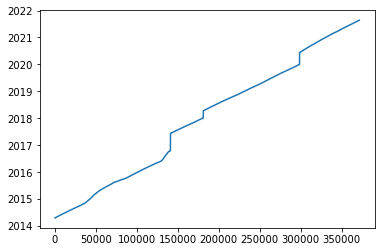

In [9]:
(iPROF, counts) = np.unique(dsTest.time, return_counts=True)

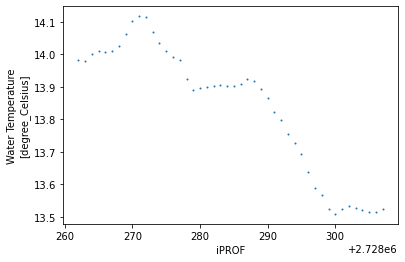

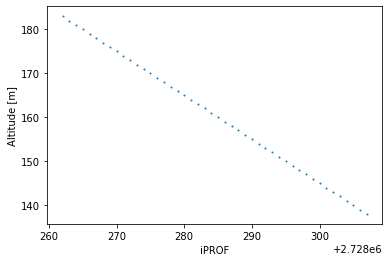

In [8]:
timeSlice = dsTest.where(dsTest.time == np.datetime64('2019-06-22T21:06:00.000000000'))
timeSlice.prof_T.plot(marker='o', linewidth=0., markersize=1)
plt.show()
timeSlice.prof_depth.plot(marker='o', linewidth=0., markersize=1)
plt.show()

Notes: apply representation error estimates. follow [this package](http://mitgcm.org/viewvc/MITgcm/MITgcm_contrib/gael/profilesMatlabProcessing/) to understand processing of data. 

Follow `~atnguyen/llc270/global/matlab/simple_ctd` to see a simple profile package use:

- weights are floats if T or S have a value, else weight is 0. Start by setting weights to 1 which is ordinary least-squares.
- ERROR: NOT Julian date, MATLab's function `datenum` generates an ordinal date whose epoch starts on January 01, 2000. Python package `datetime`'s epoch starts at the unphysical January 0, 2000! 
    
    ```
    from datetime import datetime as dt

    def datenum(d):
        return 366 + d.toordinal() + (d - dt.fromordinal(d.toordinal())).total_seconds()/(24*60*60)

    d = dt.strptime('2019-2-1 12:24','%Y-%m-%d %H:%M')
    dn = datenum(d)
   ```
- still not sure what to do about interp data variables... `prof_interp*`

In [12]:
dsTest['depth'] = xr.DataArray()

<xarray.Dataset>
Dimensions:        (iPROF: 3978245)
Dimensions without coordinates: iPROF
Data variables:
    time           (iPROF) datetime64[ns] 2014-04-15T20:00:00 ... 2021-08-22T...
    prof_S         (iPROF) float64 ...
    prof_T         (iPROF) float64 ...
    prof_Sflag     (iPROF) float64 ...
    prof_Tflag     (iPROF) float64 ...
    prof_depth     (iPROF) float64 27.0 26.0 27.0 26.0 ... 396.0 406.0 406.0
    prof_YYYYMMDD  (iPROF) float64 2.014e+07 2.014e+07 ... 2.021e+07 2.021e+07
    prof_HHMMSS    (iPROF) float64 2e+05 2e+05 2.001e+05 ... 1.818e+05 1.819e+05
Attributes:
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             feedback@axiomdatascience.com
    contributor_name:              Axiom Data Science
    contributor_role:              processor
    contributor_role_vocabulary:   NERC
    contributor_url:               https://www.axiomdatascience.com
    Conventions:                   IOOS-1.2, CF-1.6, ACDD-1.3
    creator_institution:           Ocean Observatories Initiative (OOI)
    creator_name:                  Ocean Observatories Initiative (OOI)
    creator_sector:                gov_federal
    creator_type:                  institution
    creator_url:                   https://oceanobservatories.org/
    defaultDataQuery:              sea_water_practical_salinity_profiler_dept...
    featureType:                   TimeSeriesProfile
    geospatial_lat_units:          degrees_north
    geospatial_lon_units:          degrees_east
    geospatial_vertical_positive:  up
    geospatial_vertical_units:     m
    history:                       Downloaded from Ocean Observatories Initia...
    id:                            103952
    infoUrl:                       https://sensors.ioos.us/#metadata/103952/s...
    institution:                   Ocean Observatories Initiative (OOI)
    license:                       The data may be used and redistributed for...
    naming_authority:              com.axiomdatascience
    platform:                      profiling_buoy
    platform_name:                 Coastal Pioneer: Offshore Profiler Mooring...
    platform_vocabulary:           http://mmisw.org/ont/ioos/platform
    processing_level:              Level 2
    publisher_institution:         Ocean Observatories Initiative (OOI)
    publisher_name:                Ocean Observatories Initiative (OOI)
    publisher_sector:              gov_federal
    publisher_type:                institution
    publisher_url:                 https://oceanobservatories.org/
    references:                    https://ooinet.oceanobservatories.org/data...
    sourceUrl:                     https://ooinet.oceanobservatories.org/data...
    standard_name_vocabulary:      CF Standard Name Table v72
    station_id:                    103952
    summary:                       Timeseries data from 'Coastal Pioneer: Off...
    time_coverage_end:             2021-08-22T18:19:00Z
    time_coverage_start:           2014-04-15T20:00:00Z
    title:                         Coastal Pioneer: Offshore Profiler Mooring...